In [120]:
import pandas as pd

# prophet
from prophet import Prophet
from prophet.plot import *

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# warnings
import warnings
warnings.filterwarnings('ignore')

In [121]:
# importar dados
df_ipea = pd.read_csv('/content/drive/MyDrive/PosTech_Analise_de_dados/FASE4/tech_challenge_4/dados/ipeadata_limpo.csv')
df_ipea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11188 entries, 0 to 11187
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    11188 non-null  object 
 1   valor   11188 non-null  float64
 2   ano     11188 non-null  int64  
 3   mes     11188 non-null  int64  
 4   dia     11188 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 437.2+ KB


In [122]:
df_ipea['data'] = pd.to_datetime(df_ipea['data'])

In [123]:
prophet_df_ipea = df_ipea.copy()

In [124]:
prophet_df_ipea.rename(columns={'data': 'ds','valor': 'y'}, inplace=True)
prophet_df_ipea.drop(columns=['ano', 'mes', 'dia'], axis=1, inplace=True)

In [125]:
prophet_df_ipea.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [126]:
train_ipea = prophet_df_ipea.sample(frac=0.8, random_state=0)
test_ipea = prophet_df_ipea.drop(train_ipea.index)
print(f'train: {train_ipea.shape}')
print(f'test: {test_ipea.shape}')

train: (8950, 2)
test: (2238, 2)


In [127]:
# Instanciando o Modelo
prophet = Prophet(daily_seasonality=True)

# Treinando o Modelo
prophet.fit(train_ipea)

# Realizando a Previsão 120 dias (4 meses)
df_ipea_prophet = prophet.make_future_dataframe(periods=120, freq='B')
prev_prophet = prophet.predict(df_ipea_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjiquo_h6/esj80mwf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjiquo_h6/q1120w0a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24049', 'data', 'file=/tmp/tmpjiquo_h6/esj80mwf.json', 'init=/tmp/tmpjiquo_h6/q1120w0a.json', 'output', 'file=/tmp/tmpjiquo_h6/prophet_modelhlt5raah/prophet_model-20240616025219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:52:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:52:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


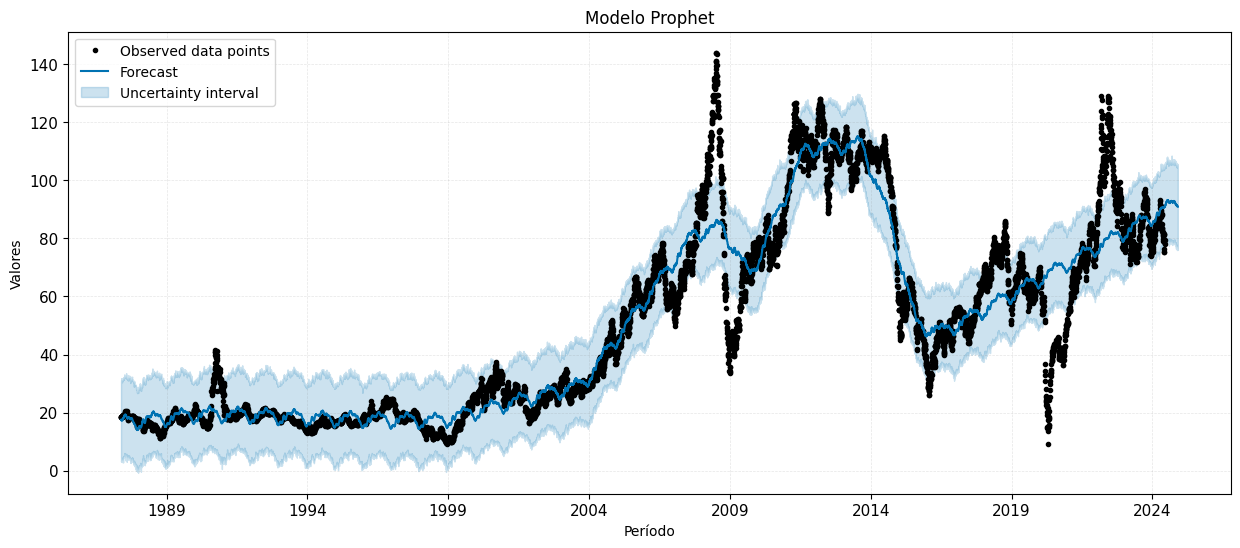

In [128]:
plt.figure(figsize=(15,6))
prophet.plot(prev_prophet, xlabel='Período', ylabel='Valores', ax=plt.gca())
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Modelo Prophet', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

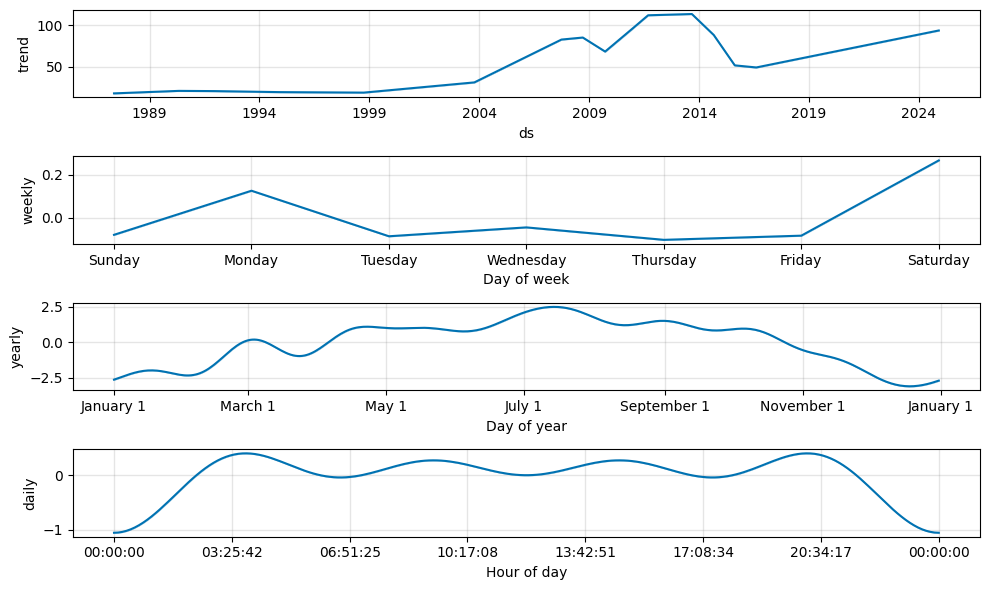

In [129]:
prophet.plot_components(prev_prophet, figsize=(10,6))
plt.show()

In [130]:
# Resultados para calcular resultados
result = pd.merge(prev_prophet[['ds', 'yhat']], train_ipea[['ds', 'y']], on='ds', how='inner')

y_result = result['y']
yhat_result = result['yhat']

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_result, yhat_result)
# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_result, yhat_result)
# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_result, yhat_result)
# Calcular o erro percentual absoluto médio (MAPE)
mape = np.mean(np.abs((y_result - yhat_result) / y_result)) * 100

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

MSE: 116.44
MAE: 6.90
R²: 0.89
MAPE: 15.37%
